In [126]:
import penemuu
import glob
import json
import spacy
import json

import en_core_web_sm
from spacy.pipeline import EntityRuler
from spacy import displacy
from penemuu import TestFunctions

from collections import defaultdict
from collections import Counter

from itertools import product

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


Generate corpus of biomedical abstracts annotated with named entities (bacterial species and habitats)
and extract sentences that contain at least one entity of each type.

In [6]:
"""
Pubmed files were downloaded using easy_pubmed_batch_downloads.R (easyPubMed R library) with a query
for "foodborne bacterial infections".

Each file contains 100 entries in MedLine format.

Available titles and/or abstracts are extracted from each entry, combined, and used to populate a 
PassageCorpus object.
"""
pubmed_files = glob.glob('penemuu/resources/pubmed/bacteria_foodborne_disease_200115/*txt')
corpus = penemuu.PassageCorpus()

for file in pubmed_files:
    corpus.add_medline_records_from_file(file)

In [7]:
"""
jsonl file for entity ruler was generated from NCBI taxonomy dump file (2/21) (bacteria) and BioNLP 
bacterial biotope .obo reference file (habitats).

PassageAnnotator contains a spaCy pipeline with an EntityRuler derived from the jsonl file.
"""
jsonl = 'penemuu/resources/entity_ruler_bacteria_habitat_200130.jsonl'

annotator = penemuu.PassageAnnotator()
annotator.add_entity_ruler_from_jsonl(jsonl)

Entity ruler generated from jsonl at penemuu/resources/entity_ruler_bacteria_habitat_200130.jsonl
Entity ruler added to spacy pipeline.
PySBDFactory added to spacy pipeline.


In [8]:
"""
Text passages are annotated for named entities and sentences containing at least 1 entity of each type are
extracted and written to a file.
"""    
outfile = 'penemuu/resources/test_sentences_with_bac_and_hab_ents_200211.txt'
sentences = TestFunctions.get_single_sentences_with_entities_by_labels(corpus, annotator, ['BACTERIA', 'HABITAT'], outfile)

"""
Filtering sentences to those with a root that is a verb or auxiliary verb eliminates titles (which are 
often not full sentences) and sentence fragments due to sentence boundary detection errors.
"""


In [21]:
"""
Separating full and non-full sentences.

Full sentences require:
    -A verb.
    -A subject.

Non-full sentences in text passages are the result of:
    -Paper titles, which are frequently incomplete sentences.
    -Sentence boundary detection errors, often resulting from the ubiquitous use of abbreviations in biomedical
    abstracts.
    -Genuinely incomplete sentences.

Paper titles:
    The logical fix for this is to handle titles and abstracts separately.  My intuition is that a title containing
    two named entities will almost always be positively linking the two.  To be added.

Sentence boundary detection:
    PassageAnnotator includes a PySBDFactory component (https://spacy.io/universe/project/python-sentence-boundary-disambiguation).
    I will manually add more scientific abbreviations to its abbrev. list as I encounter them.

Incomplete sentences:
    These seem to throw off spaCy dependency parsing in unpredictable ways


"""

full_sentences = []
sentences_without_verbs = []
sentences_with_verbs_without_subjs = []

for sent in sentences:
    
    #Verb detection
    sent_verbs = ([i for i in filter(lambda w: w.pos_ in ['VERB', 'AUX'], sent)])
    if sent_verbs:
        
        #Subject detection
        sent_subjs = ([i for i in filter(lambda w: w.dep_ in ['nsubj', 'nsubjpass', 'csubj'], sent)])
        if sent_subjs:
            full_sentences.append(sent)
        else:
            sentences_with_verbs_without_subjs.append(sent)

    else:
        sentences_without_verbs.append(sent)
        

In [25]:
"""
Sentences without verbs are mostly short fragments.

Even ones that appear very clear could be misleading without context:

"c. jejuni in the farm environment.,"

Is not useful without knowing if it's preceded by:

"Thousands of samples corroborated..."
or:
"Thousands of samples failed to corroborate..."

These may still be useful when looking at the abstract as a whole.
"""

sentences_without_verbs

[e. coli as foodborne pathogens in raw chicken and beef meat in nile delta, egypt.,
 of the 29 spinach e. coli,
 of all the food-borne pathogens, s. aureus,
 pathogenic/drug resistant e. coli in the future.,
 e. coli colonization and existence of common bile duct and gallbladder stones (p value 0.028).,
 l. monocytogenes from the brazilian dairy industry.,
 l. monocytogenes in bovine raw milk samples.,
 s. aureus in food products.,
 l. monocytogenes infection, specifically in the invasion of human intestinal epithelial cells.,
 human enteric pathogens, such as salmonella spp.,
 c. jejuni colonization in poultry in the presence of probiotics.,
 c. coli human infection.,
 l. monocytogenes from food to humans.,
 k. pneumoniae from humans and livestock.,
 foodborne k. pneumoniae to antibiotic-resistant human infections.,
 ) cfu e. coli o157:h7/g of feces.,
 resistant e. coli in raccoon feces on conservation areas versus farms; however, e. coli,
 bearing e. coli as well as a high gene trans

In [34]:
"""
Sentences with verbs but no subjects are trickier.

Some are incoherent fragments:
    "b. pinnipedialis dna to verify brucella detection by the is 711 primer-probe within fish dna."

Others are coherent but have overly passive voice:
    "e. coli (escherichia coli o157:h7-gfp b6-914), salmonella (salmonella enterica serovar enteritidis phage-type pt21), 
    and the gram-positive bacteria listeria (listeria innocua), as well as environmental microorganisms 
    derived from local river water."
    
The latter may be usable, but may be tricky to separate from the former.
    
"""

print("Sentence:")
print(sentences_with_verbs_without_subjs[0])

print("\nRoot:")
print(sentences_with_verbs_without_subjs[0].root)

displacy.render(sentences_with_verbs_without_subjs[0])

Sentence:
e. coli (escherichia coli o157:h7-gfp b6-914), salmonella (salmonella enterica serovar enteritidis phage-type pt21), and the gram-positive bacteria listeria (listeria innocua), as well as environmental microorganisms derived from local river water.

Root:
e. coli


In [45]:
verbs_used = []
verb_tokens_used = []
verb_lemmas_used = []
for sent in full_sentences:
    
    if sent.root.pos_ in ['VERB', 'AUX']:
        verbs_used.append(sent.root.text)
        verb_tokens_used.append(sent.root)
        verb_lemmas_used.append(sent.root.lemma_)
    elif sent.root.pos_ not in ['NOUN', 'PROPN']:
        print(sent)
        print(sent.root, sent.root.pos_)

twice (at day 1 and week 6) and thrice vaccination (at day 1, week 6 and 16) of laying hens with the bivalent vaccine resulted in a decreased caecal colonization by salmonella enteritidis and infantis, and significantly lower oviduct colonization levels by salmonella enteritidis.
twice ADV
all samples were cultured in blood culture media and subcultured into brucella agar medium.
cultured ADJ
c. jejuni was cultured in avian vs. mammalian mucus.
cultured ADJ
rational: salmonella enteritidis (s. enteritidis) is a globally significant zoonotic foodborne pathogen which has led to large numbers of deaths in humans and caused economic losses in animal husbandry.
rational ADJ
enterococcus faecium lineages occurring in poultry meat products are distantly related to those causing hospital-acquired infections but may act as donors of quinupristin/dalfopristin resistance and other resistance determinants of clinical interest to the human gut microbiota.
related ADJ
of 554 raw and ready-to-eat bea

In [194]:
print("Number of sentences: %d" % len(full_sentences))

print("Number of verb roots: %d" % len(verbs_used))

counted_verbs_used = Counter(verbs_used).most_common()
print("Number of verbs used: %d" % len(counted_verbs_used))

counted_verb_lemmas_used = Counter(verb_lemmas_used).most_common()
print("Number of verb lemmas used: %d" % len(counted_verb_lemmas_used))

Number of sentences: 2421
Number of verb roots: 2237
Number of verbs used: 444
Number of verb lemmas used: 306


In [195]:
counted_verb_lemmas_used

[('be', 631),
 ('isolate', 115),
 ('show', 58),
 ('use', 53),
 ('investigate', 50),
 ('detect', 48),
 ('identify', 42),
 ('find', 35),
 ('report', 32),
 ('cause', 28),
 ('indicate', 26),
 ('suggest', 26),
 ('provide', 24),
 ('associate', 24),
 ('reveal', 23),
 ('demonstrate', 23),
 ('describe', 22),
 ('observe', 20),
 ('evaluate', 20),
 ('have', 20),
 ('characterize', 16),
 ('highlight', 16),
 ('develop', 16),
 ('collect', 16),
 ('examine', 15),
 ('test', 15),
 ('contaminate', 14),
 ('conduct', 13),
 ('perform', 13),
 ('include', 13),
 ('determine', 12),
 ('result', 12),
 ('strain', 12),
 ('consider', 12),
 ('represent', 11),
 ('reduce', 11),
 ('analyze', 11),
 ('compare', 11),
 ('increase', 10),
 ('need', 10),
 ('occur', 10),
 ('require', 10),
 ('recover', 10),
 ('exhibit', 10),
 ('aim', 10),
 ('carry', 10),
 ('understand', 10),
 ('confirm', 10),
 ('link', 9),
 ('obtain', 9),
 ('lead', 8),
 ('recognize', 8),
 ('pose', 8),
 ('present', 8),
 ('affect', 7),
 ('involve', 7),
 ('apply', 7)

In [58]:
verb_tokens_used[1].similarity(verb_tokens_used[13])

/home/slander/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


0.23529983

In [64]:
verb_tokens_used[103].similarity(verb_tokens_used[110])

/home/slander/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


0.73691034

In [65]:
full_sentences[0].similarity(full_sentences[1])

/home/slander/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


0.68943715

In [76]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
full_sentences[0]

the aim of this study was to investigate the prevalence of antimicrobial resistance of salmonella isolated from turkey farms in taiwan.

In [180]:
n_dim = 50

sent_sim_array = np.zeros((n_dim, n_dim))
root_sim_array = np.zeros((n_dim, n_dim))

i = 0 
for sent_1 in full_sentences[:n_dim]:
    j = 0
    for sent_2 in full_sentences[:n_dim]:
        sent_sim_array[i][j] = sent_1.similarity(sent_2)
        root_sim_array[i][j] = sent_1.root.similarity(sent_2.root)
        j += 1
    i += 1

In [138]:
%matplotlib inline

Sentence similarity by root embedding vectors.


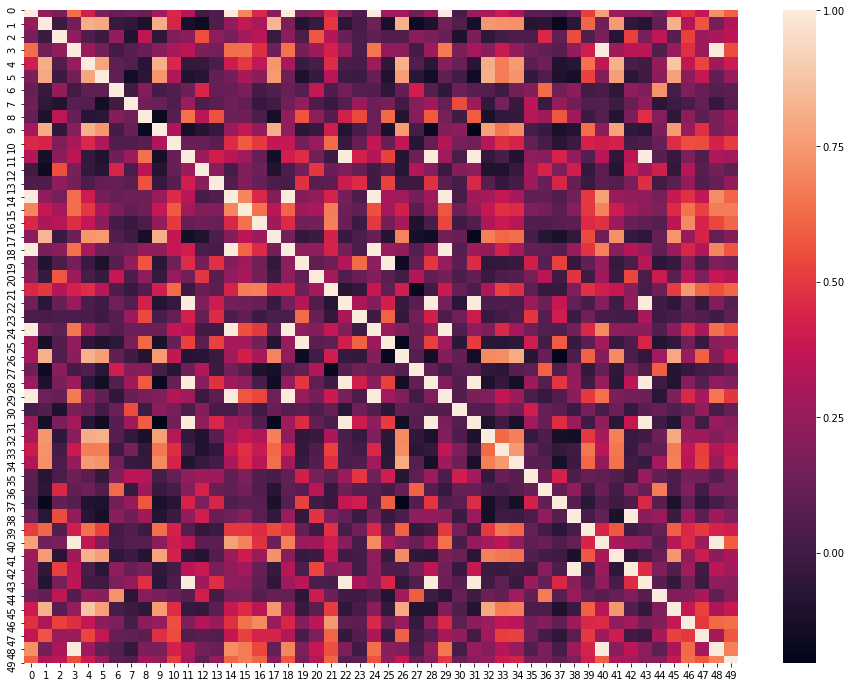

In [193]:
print("Sentence similarity by root embedding vectors.")

plt.figure(figsize=(16, 12))
sns.heatmap(root_sim_array)

Sentence similarity by averaged word embedding vectors (clustered).


<Figure size 2304x1728 with 0 Axes>

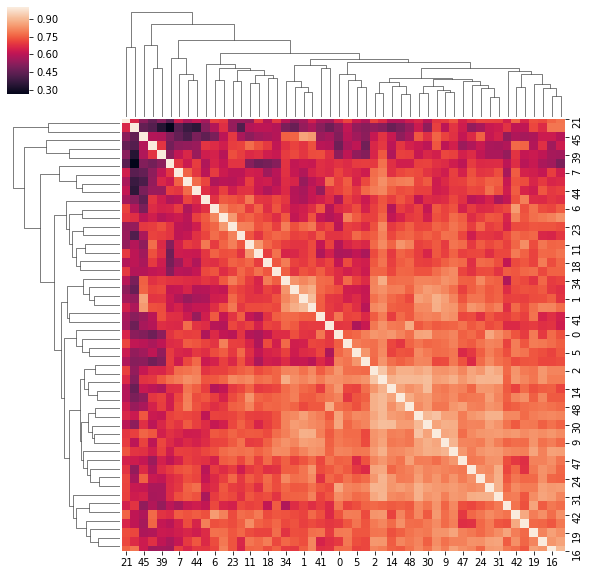

In [185]:
print("Sentence similarity by averaged word embedding vectors (clustered).")

plt.figure(figsize=(32, 24))
sns.clustermap(sent_sim_array)

In [189]:
full_sentences[34].root

detected

In [190]:
full_sentences[33].root

increased

In [154]:
nlp = spacy.load("en_core_sci_md")

In [157]:
test_doc = nlp(full_sentences[0].text)

In [198]:
test_sent = full_sentences[0]

test_sent

the aim of this study was to investigate the prevalence of antimicrobial resistance of salmonella isolated from turkey farms in taiwan.

In [159]:
displacy.render(full_sentences[0])

In [196]:
jess_sentence = 'Salmonella typhi was isolated from fermented goat cheese.'

test_doc = nlp(jess_sentence)

test_sent = next(test_doc.sents)

displacy.render(test_sent)